In order to execute this notebook you need an aws braket account and set up [aws cli](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html).
The execution of this notebook will cost around $25.  
Pulse level access through PennyLane <-> AWS on OQC Lucy is not officially released yet, so please check out [this PR](https://github.com/amazon-braket/amazon-braket-pennylane-plugin-python/pull/191) for the meantime.

In this notebook, we are calibrating the attenuation between the AWG output and the qubit.

In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax

import optax
from datetime import datetime
from tqdm.auto import trange

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

/Users/korbinianpalmarsson/anaconda3/envs/braket/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wire = 5
dev_sim = qml.device("default.qubit.jax", wires=[wire])
dev_lucy = qml.device("braket.aws.qubit",
    device_arn="arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy",
    wires=range(8), 
    shots=100,
    parallel=True
)

qubit_freq = dev_lucy.pulse_settings["qubit_freq"][wire]

In [3]:
H0 = qml.pulse.transmon_interaction(
    qubit_freq = [qubit_freq],
    connections = [],
    coupling = [],
    wires = [wire]
)
Hd0 = qml.pulse.transmon_drive(qml.pulse.constant, qml.pulse.constant, qubit_freq, wires=[wire])

@jax.jit
@qml.qnode(dev_sim, interface="jax")
def qnode_sim(params, duration):
    qml.evolve(H0 + Hd0)(params, t=duration, atol=1e-12)
    return qml.expval(qml.PauliZ(wire))

@qml.qnode(dev_lucy, interface="jax")
def qnode_lucy(params, duration):
    qml.evolve(Hd0)(params, t=duration)
    return qml.expval(qml.PauliZ(wire))

## Attenuation calibration

In [4]:
def fit_sinus(x, y, initial_guess=[1., 0.1, 1]):
    """[A, omega, phi]"""
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    # Define the function to fit (sinusoidal)
    def sinusoidal_func(x, A, omega, phi):
        return A * np.sin(omega * x + phi)

    # Perform the curve fit
    params, _ = curve_fit(sinusoidal_func, np.array(x), np.array(y), maxfev = 10000, p0=initial_guess)

    # Generate the fitted curve
    y_fit = sinusoidal_func(x_fit, *params)
    return x_fit, y_fit, params

In [5]:
sim = False
if sim:
    qnode = qnode_sim
if not sim:
    qnode = qnode_lucy

t0, t1, num_ts = 10., 25., 20
phi0 = 0.
amp0 = 0.3
x_lucy = np.linspace(t0, t1, num_ts)
name = f"data/calibration_duration_-{t0}-{t1}-{num_ts}_phi-{phi0}-amp-{amp0}-wire-{wire}"
print(name)
params = jnp.array([amp0, phi0])

y_lucy = [qnode(params, t) for t in x_lucy]

np.savez(name, x=x_lucy, y=y_lucy)

data/calibration_duration_-10.0-25.0-20_phi-0.0-amp-0.3-wire-5


/Users/korbinianpalmarsson/anaconda3/envs/braket/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Text(0.5, 0, 't1')

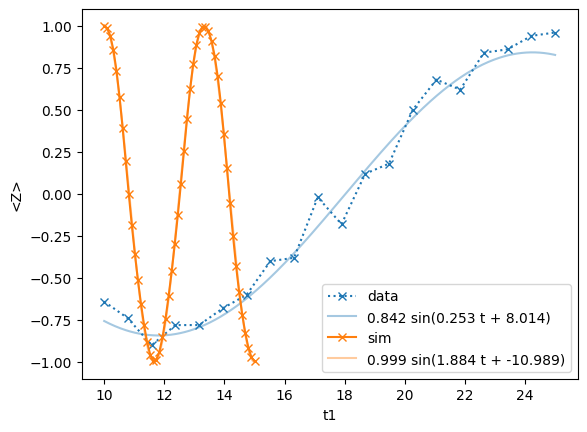

In [7]:
dat = np.load("data/calibration_duration_-10.0-25.0-20_phi-0.0-amp-0.3-wire-5.npz", allow_pickle=True)
x_lucy, y_lucy = dat["x"], dat["y"]

x_lucy_fit, y_lucy_fit, coeffs_fit_lucy = fit_sinus(x_lucy, y_lucy, [1., 0.6, 1])


plt.plot(x_lucy, y_lucy, "x:", label="data")
plt.plot(x_lucy_fit, y_lucy_fit, "-", color="tab:blue", label=f"{coeffs_fit_lucy[0]:.3f} sin({coeffs_fit_lucy[1]:.3f} t + {coeffs_fit_lucy[2]:.3f})", alpha=0.4)

params_sim = jnp.array([amp0, phi0])
x_sim = jnp.linspace(10., 15., 50)
y_sim = jax.vmap(qnode_sim, (None, 0))(params_sim, x_sim)
x_fit, y_fit, coeffs_fit_sim = fit_sinus(x_sim, y_sim, [2., 1., -np.pi/2])

plt.plot(x_sim, y_sim, "x-", label="sim")
plt.plot(x_fit, y_fit, "-", color="tab:orange", label=f"{coeffs_fit_sim[0]:.3f} sin({coeffs_fit_sim[1]:.3f} t + {coeffs_fit_sim[2]:.3f})", alpha=0.4)
plt.legend()
plt.ylabel("<Z>")
plt.xlabel("t1")

#plt.savefig("../../qml/demonstrations/oqc_pulse/calibration0.png", dpi=400)

In [8]:
attenuation = np.abs(coeffs_fit_lucy[1] / coeffs_fit_sim[1])
attenuation

0.1340400105521491

Text(0.5, 0, 't1')

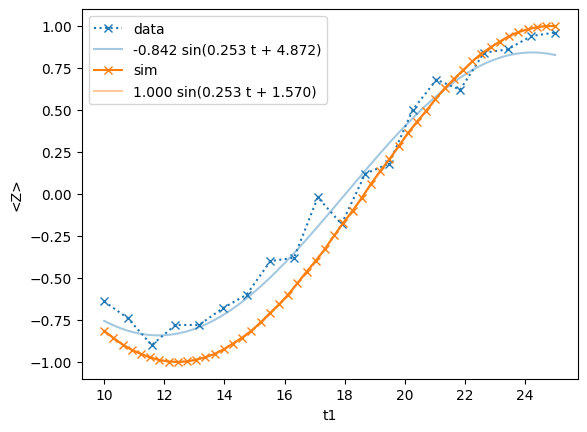

In [9]:
dat = np.load("data/calibration_duration_-10.0-25.0-20_phi-0.0-amp-0.3-wire-5.npz", allow_pickle=True)
x_lucy, y_lucy = dat["x"], dat["y"]

x_lucy_fit, y_lucy_fit, coeffs_fit_lucy = fit_sinus(x_lucy, y_lucy, [1., 0.5, 1])


plt.plot(x_lucy, y_lucy, "x:", label="data")
plt.plot(x_lucy_fit, y_lucy_fit, "-", color="tab:blue", label=f"{coeffs_fit_lucy[0]:.3f} sin({coeffs_fit_lucy[1]:.3f} t + {coeffs_fit_lucy[2]:.3f})", alpha=0.4)

params_sim = jnp.array([attenuation*amp0, phi0])
x_sim = jnp.linspace(10., 25., 50)
y_sim = jax.vmap(qnode_sim, (None, 0))(params_sim, x_sim)
x_fit, y_fit, coeffs_fit_sim = fit_sinus(x_sim, y_sim, [2., 0.5, -np.pi/2])

plt.plot(x_sim, y_sim, "x-", label="sim")
plt.plot(x_fit, y_fit, "-", color="tab:orange", label=f"{coeffs_fit_sim[0]:.3f} sin({coeffs_fit_sim[1]:.3f} t + {coeffs_fit_sim[2]:.3f})", alpha=0.4)
plt.legend()
plt.ylabel("<Z>")
plt.xlabel("t1")

#plt.savefig("../../qml/demonstrations/oqc_pulse/calibration0.png", dpi=400)